# From Correlation to Causation: Estimating Effective Connectivity from Zero-Lag Covariances of Brain Signals 
Jonathan Schiefer, Alexander Niederbühl, Volker Pernice, Carolin Lennartz, Jürgen Hennig, Pierre LeVan and Stefan Rotter

In this notebook, it is shown how the results in the paper were achieved. The figures are created within to notebook, so they are not the same as in the paper. For the results in the paper we used a longer simulation duration.

## Simulation

In [1]:
%matplotlib inline
from IPython.display import Latex
import simulation_functions as sf
import numpy as np
import pylab as plt

In [2]:
N = 100
p = 0.1
rho = 0.3
tau = 0.1
sigma = 1.
simDur = 200000
dt = 0.1

In [3]:
# Generate connectivity matrix, subtract 0.5 to guarantee that approximately 50% of the connections are inhibitory
G0 = np.random.random((N, N)) - 0.5
G0[abs(G0) < (1 - p) * .5] = 0  # set all connections but 10% to 0
G0 = np.sign(G0)  # set all connections to equal strength
G0 -= np.diag(np.diag(G0))  # set diagonal to 0 to avoid self-connections

data= sf.orn_uhl(G0, simDur, rho, p, tau, dt, sigma)  # simulate data
data_filtered = sf.filter_data(data, dt)  # filter data with canonical HRF
# calculate zero-lag covariances
C = sf.calc_inst_cov(data_filtered, mode='time')


## Estimate Connectivity

In [4]:
import gradient_methods as gr
import helper_functions as hf

In [5]:
    xtol = 1e-3
    gtol = 1e-3
    ftol = 1e-5

In [6]:
B0 = hf.B_from_C(C)  # calculate initial condition
G_est = gr.conjugate(B0, xtol, gtol, ftol)  # estimate connectivity

reached max iteration


## Evaluate performance
We use the 'Area under the ROC curve' (AUC), the 'precision recall score' (PRS) and 'Pearson Correlation Coefficient' (PCC) as performance measures.

AUC: 0.971184713449
PRS: 0.959359766315
PCC: 0.93524220184
True positives: 913
True negatives: 8948
False positives: 87
Flase negatives: 52


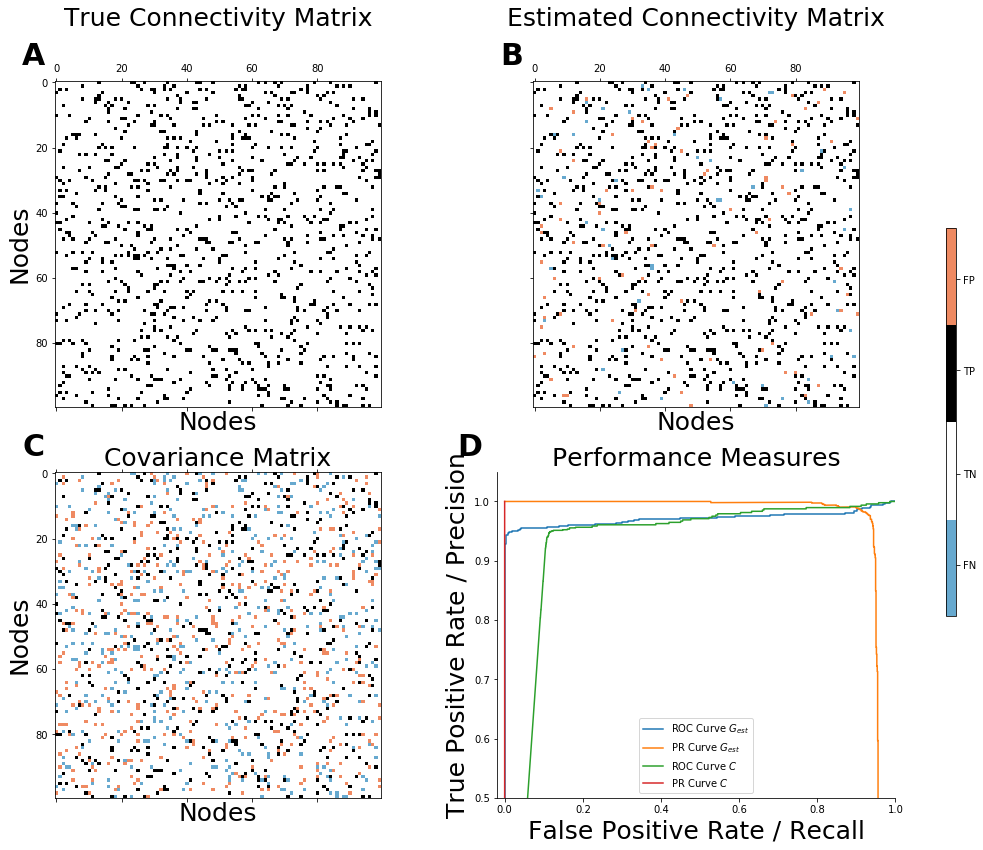

In [7]:
hf.plot_networks(G0, G_est, C, 10.)

## Clean covariance matrices

In this part of the paper, the covariance matrices are calculated directly from the connectivity matrix according to the model, Eq 5 in the paper: 
\begin{equation}
 \hat{C}^{-1} = \left( 1 -\hat{G}^* \right) \left(1 - \hat{G} \right) = 1 - \hat{G}^* - \hat{G} + \hat{G}^* \hat{G}  \end{equation}

In the paper it is done for 20 repetitions, here only for one, that's why there is no variation (shaded area) in the plots.
### Spectral radius
First, we study the effect of the spectral radius. The operations performed are the same as in the example above, please note the comments there.

converged
converged
converged
converged
converged
converged
converged
converged
converged


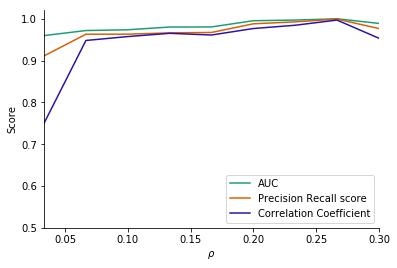

In [13]:
strengths = np.arange(0.1, 1., 0.1)
Js = []
aucs = np.zeros(len(strengths))
prs = np.zeros(len(strengths))
pccs = np.zeros(len(strengths))
for j, s in enumerate(strengths):
    J = np.sqrt(s**2 / (p * (1 - p) * N))
    Js.append(J)
    G = np.random.rand(N, N) - 0.5
    G[abs(G) < (1 - p) * 0.5] = 0.
    G = J * np.sign(G)
    G -= np.diag(np.diag(G))
    G = np.matrix(G)
    # Calculate the inverse covriance model according to the model (Equation 5 in the paper)
    Cinv = np.eye(N) - G - G.H + G.H * G
    B0 = hf.B_from_CI(Cinv)
    G_est = gr.conjugate(B0)
    aucs[j], prs[j] = hf.get_performance(G, G_est)
    pccs[j] = np.corrcoef(G.flatten(), G_est.flatten())[0, 1]


hf.plot_results(Js, aucs, None, prs, None, pccs, None, r'$\rho$')

### Connection probability
Secondly, we study the effect of the connection probability

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


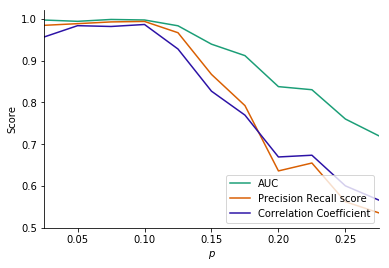

In [16]:
rho = 0.7

ps = np.arange(0.025, 0.3, 0.025)
aucs = np.zeros(len(ps))
prs = np.zeros(len(ps))
pccs = np.zeros(len(ps))
for j, p in enumerate(ps):
    s = np.sqrt(rho**2 / (p * (1 - p) * N))
    G = np.random.rand(N, N) - 0.5
    G[abs(G) < (1 - p) * 0.5] = 0.
    G = s * np.sign(G)
    G -= np.diag(np.diag(G))
    G = np.matrix(G)
    Cinv = np.eye(N) - G - G.H + G.H * G
    B0 = hf.B_from_CI(Cinv)
    G_est = gr.conjugate(B0)
    aucs[j], prs[j] = hf.get_performance(G, G_est)
    pccs[j] = np.corrcoef(G.flatten(), G_est.flatten())[0, 1]


hf.plot_results(ps, aucs, None, prs, None, pccs, None, r'$p$')

## Network size
And thirdly, we study the effect of the network size

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


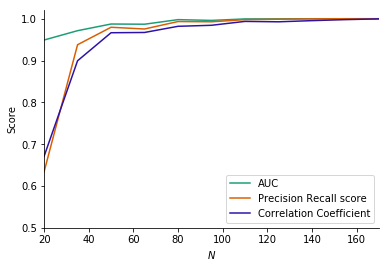

In [17]:
rho = 0.7
p = 0.1
Ns = np.arange(20, 185, 15)
aucs = np.zeros(len(Ns))
prs = np.zeros(len(Ns))
pccs = np.zeros(len(Ns))
for j, N in enumerate(Ns):
    s = np.sqrt(rho**2 / (p * (1 - p) * N))
    G = np.random.rand(N, N) - 0.5
    G[abs(G) < (1 - p) * 0.5] = 0.
    G = s * np.sign(G)
    G -= np.diag(np.diag(G))
    G = np.matrix(G)
    Cinv = np.eye(N) - G - G.H + G.H * G
    B0 = hf.B_from_CI(Cinv)
    G_est = gr.conjugate(B0)
    aucs[j], prs[j] = hf.get_performance(G, G_est)
    pccs[j] = np.corrcoef(G.flatten(), G_est.flatten())[0, 1]

hf.plot_results(Ns, aucs, None, prs, None, pccs, None, r'$N$')

## Ornstein-Uhlenbeck processes as model for BOLD signals
### Unobserved nodes
For investiagting the effect of unobserved nodes, we artificially remove parts of the data. Then we try to estimate the connectivity based on this reduced dataset and evaluate the performance regarding the corresponding sub-network. In the paper a bigger network (180 Nodes) is used. 

reached max iteration
reached max iteration
reached max iteration
reached max iteration
reached max iteration


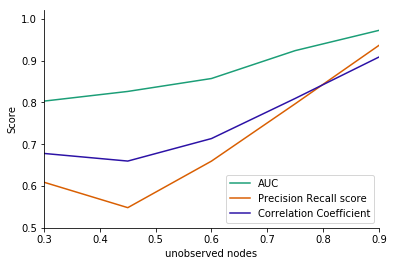

In [18]:
N = 100
Ms = np.arange(30, 100, 15)
aucs = np.zeros(len(Ms))
prs = np.zeros(len(Ms))
pccs = np.zeros(len(Ms))
for ind, M in enumerate(Ms):
    data_reduced = None
    H = G0[:M, :M]
    data_reduced = data_filtered[:M, :]
    C = sf.calc_inst_cov(data_reduced)
    B0 = hf.B_from_C(C)
    G_est = gr.conjugate(B0, xtol, gtol, ftol)
    aucs[ind], prs[ind] = hf.get_performance(H, G_est)
    pccs[ind] = np.corrcoef(H.flatten(), G_est.flatten())[0, 1]

hf.plot_results(np.array(Ms) / float(N), aucs, None, prs,
                None, pccs, None, 'unobserved nodes')

## Signal-to-noise ratio
Here we study the effect of observation noise.

reached max iteration
reached max iteration
reached max iteration
reached max iteration
reached max iteration
reached max iteration


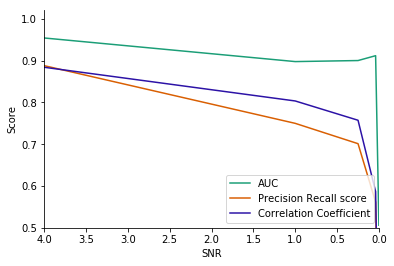

In [19]:
sigmas = np.array([.5, 1., 2., 5., 10., 30.])
SNRs = np.zeros(len(sigmas))
aucs = np.zeros(len(sigmas))
prs = np.zeros(len(sigmas))
pccs = np.zeros(len(sigmas))
for q, sigma in enumerate(sigmas):
    data_noisy = None
    noise = np.random.normal(0, sigma, (N, int(simDur * (1. / dt))))
    data_noisy = data + noise
    data_noisy = hf.norm_data(data_noisy)
    C = sf.calc_inst_cov(data_noisy)
    B0 = hf.B_from_C(C)
    G_est = gr.conjugate(B0, xtol, gtol, ftol)
    aucs[q], prs[q] = hf.get_performance(G0, G_est)
    pccs[q] = abs(np.corrcoef(G0.flatten(), G_est.flatten()))[0, 1]
    SNRs[q] = np.mean(np.std(data, axis=-1)**2 / np.std(noise, axis=-1)**2)

hf.plot_results(SNRs, aucs, None, prs, None, pccs, None, 'SNR')
